In [169]:
import utils
import Graphs
import tradingBot
from sklearn.metrics import mean_squared_error
import numpy as np
from keras import layers, models, activations

In [170]:
path = 'nasdaq-index-365.json'

In [171]:
raw_data = utils.getData(path)

In [172]:
max_open = max(item["open"] for item in raw_data)
min_open = min(item["open"] for item in raw_data)

normalized_data = utils.normalize(raw_data, max_open, min_open)

In [173]:
((train_data_4days, train_labels_4days), (validation_data_4days, validation_labels_4days),
 (test_data_4days, test_labels_4days)) = utils.genTrainData4DaysBf(normalized_data)

In [174]:
def build_model_regression(input_data_shape):
    model = models.Sequential()
    model.add(layers.Dense(20, activation=activations.tanh, input_shape=[input_data_shape, ]))
    model.add(layers.Dense(40, activation=activations.tanh))
    model.add(layers.Dense(20, activation=activations.tanh))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K - fold validation

In [175]:
k = 7
num_val_samples = len(train_data_4days) // k
num_epoch = 40
all_history = []
train_data_4days = np.array(train_data_4days)
train_labels_4days = np.array(train_labels_4days)
model = build_model_regression(train_data_4days.shape[1])

In [176]:
# Tecnica de K-fold.
for i in range(k):
    print("Fold ", i)
    validation_data = train_data_4days[i * num_val_samples:(i+1) * num_val_samples]
    validation_targets = train_labels_4days[i * num_val_samples:(i+1) * num_val_samples]
    partial_train_data = np.concatenate([train_data_4days[:i * num_val_samples],train_data_4days[(i+1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_labels_4days[:i * num_val_samples],train_labels_4days[(i+1) * num_val_samples:]],axis=0)
    input_layer_size = partial_train_data.shape[1]
    #model = utils.build_model_regression(input_layer_size)
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epoch, batch_size = 16, 
                        validation_data = (validation_data, validation_targets),
                        verbose=0)
    all_history.append(history.history['val_mae'])

Fold  0
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6


In [177]:
predicted_values = model.predict(test_data_4days)
predicted_values = utils.desnormalizeList(predicted_values, max_open, min_open)
real_values = utils.desnormalize(test_labels_4days, max_open, min_open)

mse = mean_squared_error(real_values, predicted_values)

print('Error cuadratico medio: ' + str(mse))
print("=====================================")

2/2 [==============================] - 0s 2ms/step
Error cuadratico medio: 2354.1221922685586


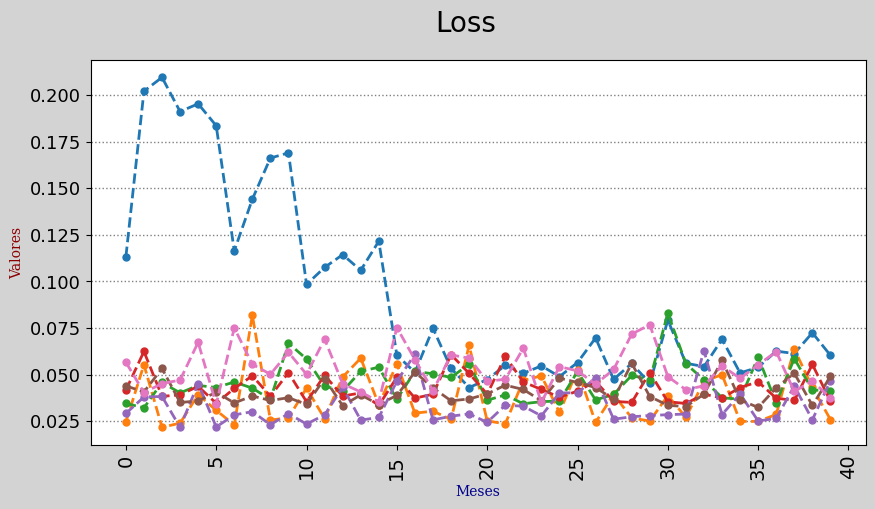

In [178]:
Graphs.plotResultsLoss(all_history)

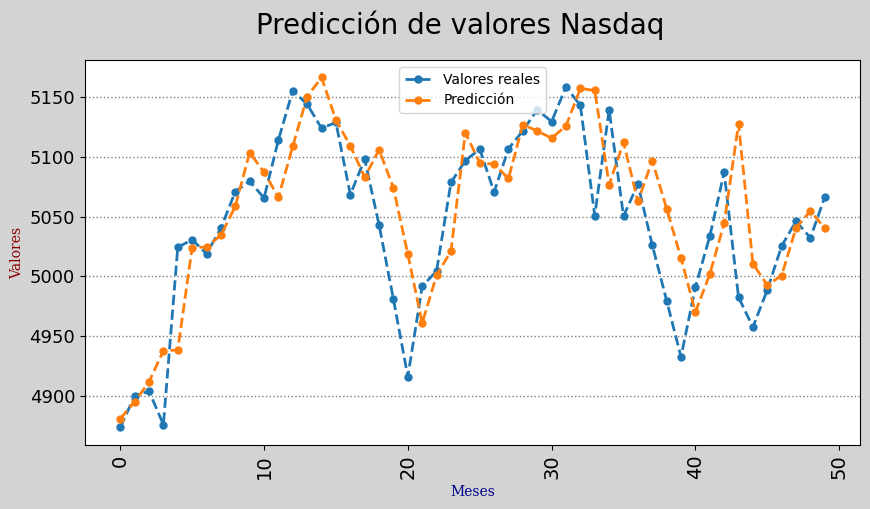

In [179]:
Graphs.plotResultsStocks([real_values, predicted_values])

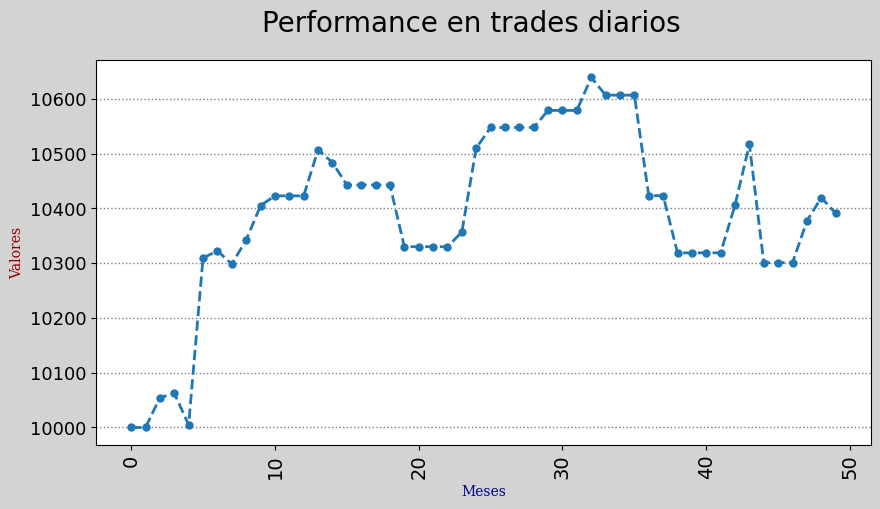

In [180]:
simu_balance = tradingBot.simulation(real_values, predicted_values)
Graphs.plotResultsTrades([simu_balance])